In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics

# data pre-processing 

In [2]:
train = pd.read_csv("data/train.csv")
train.SalePrice = np.log(train.SalePrice)

test = pd.read_csv("data/test.csv")
y_test = pd.read_csv("data/sample_prediction.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


## features

In [4]:
continuous_features = ["MSSubClass",   "LotFrontage",  "LotArea",      "OverallQual", "OverallQual", 
                       "YearBuilt",    "YearRemodAdd", "MasVnrArea",   "BsmtFinSF1",  "BsmtFinSF2",  
                       "BsmtUnfSF",    "TotalBsmtSF",  "1stFlrSF",     "2ndFlrSF",    "LowQualFinSF", 
                       "GrLivArea",    "BsmtFullBath", "BsmtHalfBath", "FullBath",    "HalfBath",    
                       "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",  "GarageYrBlt",  
                       "GarageCars",   "GarageArea",   "WoodDeckSF",   "OpenPorchSF", "EnclosedPorch",
                       "3SsnPorch",    "ScreenPorch",  "PoolArea",     "MiscVal",     "MoSold", 
                       "YrSold"]

ordinal_features = ["Street",       "Alley",        "LotShape",     "Utilities",   "LandSlope",    
                    "ExterQual",    "LandContour",  "ExterCond",    "BsmtQual",    "BsmtCond",   
                    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC",   "CentralAir", 
                    "Electrical",   "KitchenQual",  "Functional",   "FireplaceQu", "GarageType", 
                    "GarageFinish", "GarageQual",   "GarageCond",   "PavedDrive",  "PoolQC", 
                    "Fence"] 

categorical_features = ["LotConfig",  "Neighborhood", "Condition1",  "Condition2",  "HouseStyle", 
                        "RoofStyle",  "RoofMatl",     "Exterior1st", "Exterior2nd", "MasVnrType", 
                        "Foundation", "Heating",      "MiscFeature", "SaleType",    "SaleCondition", 
                        "MSZoning",   "BldgType"]

## check for na values

In [5]:
def check_na(df):
    i = 0
    print("Missed values:")
    
    for col in df.columns:
        if (df[col].dropna().count() < df.index).any():
            print("  {}: {} values".format(col, df[col].dropna().count()))
            i += 1
            
    if i == 0:
        print("  No missed values")
        
    return str(i) + " strings with missed values"

In [6]:
print(check_na(train))

print('\n\n')

print(check_na(test))

Missed values:
  LotFrontage: 1201 values
  Alley: 91 values
  MasVnrType: 1452 values
  MasVnrArea: 1452 values
  BsmtQual: 1423 values
  BsmtCond: 1423 values
  BsmtExposure: 1422 values
  BsmtFinType1: 1423 values
  BsmtFinType2: 1422 values
  FireplaceQu: 770 values
  GarageType: 1379 values
  GarageYrBlt: 1379 values
  GarageFinish: 1379 values
  GarageQual: 1379 values
  GarageCond: 1379 values
  PoolQC: 7 values
  Fence: 281 values
  MiscFeature: 54 values
18 strings with missed values



Missed values:
  MSZoning: 1455 values
  LotFrontage: 1232 values
  Alley: 107 values
  Utilities: 1457 values
  MasVnrType: 1443 values
  MasVnrArea: 1444 values
  BsmtQual: 1415 values
  BsmtCond: 1414 values
  BsmtExposure: 1415 values
  BsmtFinType1: 1417 values
  BsmtFinType2: 1417 values
  BsmtFullBath: 1457 values
  BsmtHalfBath: 1457 values
  Functional: 1457 values
  FireplaceQu: 729 values
  GarageType: 1383 values
  GarageYrBlt: 1381 values
  GarageFinish: 1381 values
  GarageQual: 1

## fill NA values

In [7]:
# linear regression LotArea ~ LotFrontage

area_df = train[["LotFrontage", "LotArea"]].dropna()
x_area = np.array(area_df.LotFrontage).reshape(-1, 1)
y_area = area_df.LotArea

lm = LinearRegression()
lm = lm.fit(x_area, y_area)

train.loc[train.LotFrontage.isna(), 'LotFrontage'] = np.sqrt(train.LotArea) * lm.coef_ + lm.intercept_
test.loc[test.LotFrontage.isna(), 'LotFrontage'] = np.sqrt(test.LotArea) * lm.coef_ + lm.intercept_

In [8]:
# features, that can be interpreted as int value

transform = {"Street":      {"NA":  0, "Grvl":  1, "Pave":   2},
            "Alley":        {"NA":  0, "Grvl":  1, "Pave":   2},
            "LotShape":     {"NA":  0, "IR3":   1, "IR2":    2, "IR1":    3, "Reg":    4},
            "Utilities":    {"NA":  0, "ELO":   1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}, 
            "LandSlope":    {"NA":  0, "Sev":   1, "Mod":    2, "Gtl":    3}, 
            "LandContour":  {"NA":  0, "Low":   1, "HLS":    2, "Bnk":    3, "Lvl":    4},
            "ExterQual":    {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5},
            "ExterCond":    {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "BsmtQual":     {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "BsmtCond":     {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "BsmtExposure": {"NA":  0, "No":    1, "Mn":     2, "Av":     3, "Gd":     4}, 
            "BsmtFinType1": {"NA":  0, "Unf":   1, "LwQ":    2, "Rec":    3, "BLQ":    4, "ALQ":   5, "GLQ":  6}, 
            "BsmtFinType2": {"NA":  0, "Unf":   1, "LwQ":    2, "Rec":    3, "BLQ":    4, "ALQ":   5, "GLQ":  6}, 
            "HeatingQC":    {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5},
            "CentralAir":   {"NA":  0, "N":     1, "Y":      2}, 
            "Electrical":   {"NA":  0, "Mix":   1, "FuseP":  2, "FuseF":  3, "FuseA":  4, "SBrkr": 5}, 
            "KitchenQual":  {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "Functional":   {"NA":  0, "Sal":   1, "Sev":    2, "Maj2":   3, "Maj1":   4, "Mod":   5, "Min2":  6, "Min1": 7, "Typ": 8},
            "FireplaceQu":  {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "GarageType":   {"NA":  0, "Detchd":1, "CarPort":2, "BuiltIn":3, "Basment":4, "Attchd":5, "2Types":6},
            "GarageFinish": {"NA":  0, "Unf":   1, "RFn":    2, "Fin":    3}, 
            "GarageQual":   {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "GarageCond":   {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "PavedDrive":   {"NA":  0, "N":     1, "P":      2, "Y":      3}, 
            "PoolQC":       {"NA":  0, "Po":    1, "Fa":     2, "TA":     3, "Gd":     4, "Ex":    5}, 
            "Fence":        {"NA":  0, "MnWw":  1, "GdWo":   2, "MnPrv":  3, "GdPrv":  4}, 
           }

In [9]:
for col in transform.keys():
    train[col].fillna("NA", inplace=True)
    test[col].fillna("NA", inplace=True)  
    
    train[col] = train[col].map(transform[col])
    test[col]  = test[col].map(transform[col])

In [10]:
for col in continuous_features:
    train.loc[train[col].isna(), col] = train[col].median()
    test.loc[test[col].isna(), col]   = test[col].median()

In [11]:
for col in categorical_features + ordinal_features:
    train.loc[train[col].isna(), col] = train[col].value_counts().index[0]
    test.loc[test[col].isna(), col]   = test[col].value_counts().index[0]

In [12]:
print(check_na(train))

print('\n')

print(check_na(test))


(train.isna().values.any() == False) and (test.isna().values.any() == False)

Missed values:
  No missed values
0 strings with missed values


Missed values:
  No missed values
0 strings with missed values


True

## categorical_features to ordinal_features

In [13]:
for col in categorical_features:
    if col not in ["Neighborhood", "BldgType", "HouseStyle", "MSZoning"]:
          
        order = train[[col, "SalePrice"]].groupby(col).SalePrice.median().sort_values() 

        transf = {col: {order.index.values[i]: i for i in range(len(order))}}
        
        train[col] = train[col].map(transf[col])
        test[col]  = test[col].map(transf[col])
        
        ordinal_features.append(col)

In [14]:
for col in ["Neighborhood", "MSZoning", "MSSubClass", "BldgType", "HouseStyle"]:
    binar = LabelBinarizer()
    binar.fit(train[col])
    
    binarized = pd.DataFrame(binar.transform(train[col]), columns=binar.classes_, index=train.Id)
    train = pd.merge(train, binarized, on='Id')
    train.drop(col, axis=1, inplace=True)
    
    binarized = pd.DataFrame(binar.transform(test[col]),  columns=binar.classes_, index=test.Id)
    test = pd.merge(test, binarized, on='Id')
    test.drop(col, axis=1, inplace=True)
continuous_features.remove("MSSubClass")

In [15]:
train.head()

,Id,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Twnhs,TwnhsE,1.5Fin,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,1,65.0,8450.0,2,0,4,4,4,0,3,...,0,0,0,0,0,0,0,1,0,0
1,2,80.0,9600.0,2,0,4,4,4,2,3,...,0,0,0,0,1,0,0,0,0,0
2,3,68.0,11250.0,2,0,3,4,4,0,3,...,0,0,0,0,0,0,0,1,0,0
3,4,60.0,9550.0,2,0,3,4,4,1,3,...,0,0,0,0,0,0,0,1,0,0
4,5,84.0,14260.0,2,0,3,4,4,2,3,...,0,0,0,0,0,0,0,1,0,0


# visualisation

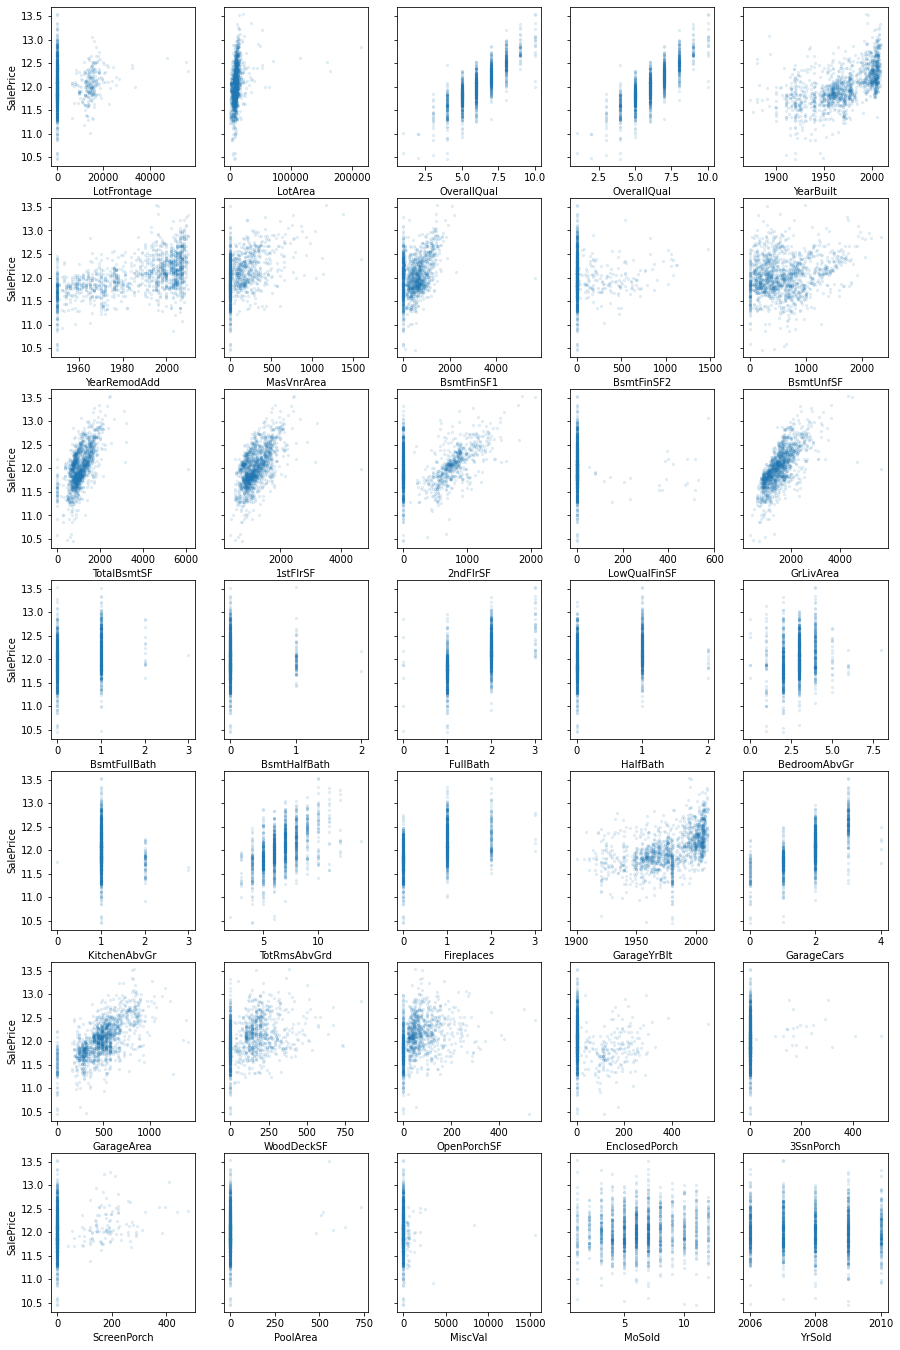

In [16]:
f, ax = plt.subplots(7, 5, figsize=(15, 24), sharey=True)
ax = np.ravel(ax)

for i in range(len(continuous_features)):
    train.plot.scatter(x=continuous_features[i], y='SalePrice', alpha=0.1, legend=True, s=5, ax=ax[i])

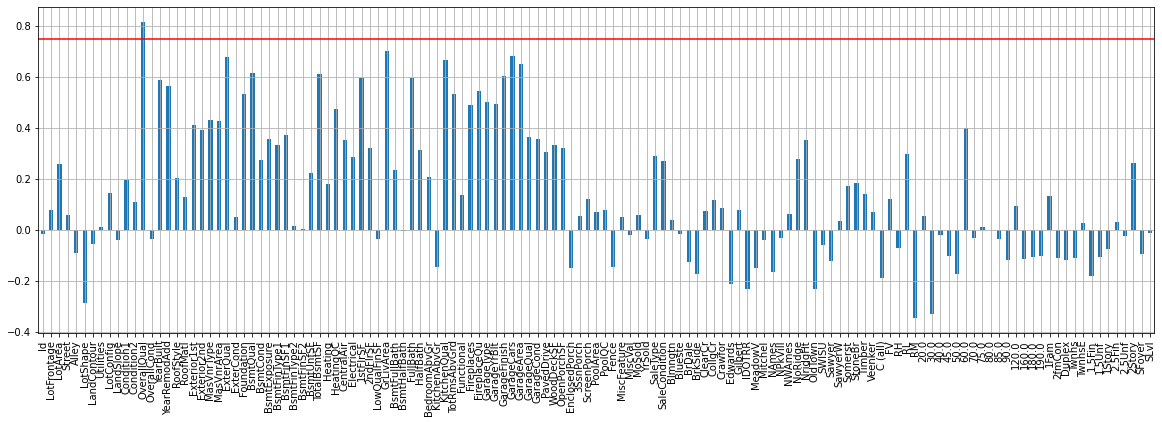

In [17]:
f, ax = plt.subplots(figsize=(20,6))

train.drop("SalePrice", axis=1).corrwith(train.SalePrice).plot.bar()
ax.plot(ax.get_xlim(), [0.75, 0.75], color='red')
ax.grid()

# model build and prediction

In [18]:
alphas = np.linspace(0.01, 1, 20)

ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(train.drop("SalePrice", axis=1), train.SalePrice)

RidgeCV(alphas=array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
        cv=5)

In [19]:
predict = pd.DataFrame(np.exp(ridge_model.predict(test)), columns=["SalePrice"], index=test.Id)
predict.to_csv('prediction.csv', index='Id')

In [20]:
predict

,SalePrice
Id,
1461,119009.879909
1462,143089.259801
1463,166987.784609
1464,190529.280368
1465,204106.456264
...,...
2915,78438.829227
2916,78679.125472
2917,152644.229878


In [21]:
print("mean absolute error: ", np.sqrt(metrics.mean_squared_error(y_test.SalePrice, predict)))

mean absolute error:  70999.2549682085
